# Qiskit Patterns

In this how-to we will learn about Qiskit patterns and quantum approximate optimization. Qiskit Patterns are a workflow to execute a task on a Quantum computer. They comprise four steps

1. Map the classical inputs to a quantum problem
2. Optimize problem for quantum execution
3. Execute using Qiskit Runtime primitives
4. Post-process, return result in classical format

We will apply the patterns to the context of **combinatorial optimization** and show how to solve a problem using the **Quantum Approximate Optimization Algorithm (QAOA)**, a hybrid (quantum-classical) iterative method. 

- In Step 1. we will take a combinatorial optimization problem and formulate it in terms of finding the ground state of an Ising Hamiltonian. This reformulated problem can be understood by a quantum computer.
- In Step 2. we will prepare the quantum circuits to execute on the quantum computer.
- In Step 3. we will iterativelly call the `Sampler` primitive in Qiskit to draw samples from the quantum circuits that Step 2. prepared., and use those samples in the loss function of our algorithmic routine
- Finally, under Step 4. we convert the samples from Step 3. into the solution of our combinatorial optimization problem. 

## 1. Map the classical inputs to a quantum problem

We are interested in solving a classical combinatorial optimization problem which has the form

\begin{align}
\min_{x\in \{0, 1\}^n}f(x)
\end{align}

Here, the vector $x$ are the $n$ decision variables. As you can see, there is nothing relating to quantum computing here yet. We therefore need to reformulate this problem into something that a quantum computer can understand. To be more concrete, we will consider a Quadratic Unconstrained Binary Optimization problem with the form

\begin{align}
\min_{x\in \{0, 1\}^n}x^T Q x,
\end{align}

where $Q$ is a $n\times n$ matrix of real numbers. 

As example of a QUBO, we will focus on a maximum cut problem where we seek to partition the nodes of a graph into to sets such that the number of edges traversed by this cut is maximum. Note that we will consider a problem with both positive (green) and negative (red) weights.

![here](data/125node_example.png)

Classical optimization problems and be stored and represented in a LP as shown below. This is a representation of the Maxcut problem we want to solve.

In [21]:
with open("data/125node_example.lp", "r") as file:
    problem = file.read()
print(problem)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ - 8 x0^2 + 8 x0*x1 + 8 x0*x13 - 8 x1^2 + 8 x1*x2 - 8 x2*x3 + 8 x3*x4
      - 4 x4^2 - 8 x4*x5 + 8 x4*x14 + 8 x5*x6 - 8 x6^2 + 8 x6*x7 - 8 x7^2
      + 8 x7*x8 - 12 x8^2 + 8 x8*x9 + 8 x8*x15 - 8 x9*x10 + 8 x10^2 - 8 x10*x11
      + 8 x11*x12 - 8 x12*x16 - 8 x13*x17 - 8 x14*x21 - 8 x15*x25 + 8 x16^2
      - 8 x16*x29 + 8 x17*x18 - 8 x18^2 + 8 x18*x19 + 4 x19^2 - 8 x19*x20
      - 8 x19*x32 + 8 x20*x21 - 4 x21^2 + 8 x21*x22 - 8 x22^2 + 8 x22*x23
      - 12 x23^2 + 8 x23*x24 + 8 x23*x33 - 8 x24^2 + 8 x24*x25 + 4 x25^2
      - 8 x25*x26 + 8 x26*x27 - 4 x27^2 + 8 x27*x28 - 8 x27*x34 - 8 x28*x29
      + 12 x29^2 - 8 x29*x30 + 8 x30^2 - 8 x30*x31 + 8 x31^2 - 8 x31*x35
      + 8 x32*x38 - 8 x33*x42 + 8 x34^2 - 8 x34*x46 + 8 x35^2 - 8 x35*x50
      - 8 x36^2 + 8 x36*x37 + 8 x36*x51 - 8 x37*x38 - 4 x38^2 + 8 x38*x39
      - 8 x39*x40 + 12 x40^2 - 8 x40*x41 - 8 x40*x52 + 8 x41^2 - 8 x41*x42
     

To start, we will convert the binary variables $x_i$ to variables $z_i\in\{-1, 1\}$ by doing

\begin{align}
x_i = \frac{1-z_i}{2}.
\end{align}

Here, for example, we see that if $x_i$ is $0$ then $z_i$ is $1$. When we substitute the $x_i$'s for the $z_i$'s in the QUBO above, we obtain the equivalent formulations for our optimization task

\begin{align}
\min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align}

The details of the computation are shown in Appendix A below. Here, $b$ depends on $Q$. Note that to obtain $z^TQz + b^Tz$ we dropped an irrelevant factor of 1/4 and a constant offset of $n^2$ which do not play a role in the optimization. Now, to obtain a quantum formulation of the problem we promot the $z_i$ variables to a Pauli $Z$ matrix, i.e., a $2\times 2$ matrix of the form

\begin{align}
Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
\end{align}

When we substitute these matrices in the QUBO above we obtain the following Hamiltonian

\begin{align}
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
\end{align}

We refer to this Hamiltonian as the **cost function Hamiltonian**. It has the property that its gound state corresponds to the solution that **minimizes the cost function $f(x)$**.
Therefore, to solve our optimization problem we now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min f(x)$.

In [29]:
with open("data/125node_example_ising.txt") as input_file:
    for _ in range(10):
        print(str(next(input_file)).replace("\n", ""))

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII, -1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIZIIII, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII, -1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## 2. Optimize problem for quantum execution

(*In Step 2. we will prepare the quantum circuits to execute on the quantum computer.*)

The Hamiltonian $H_c$ obtained from step 1 contains the quantum definition of our problem. We will now create a quantum circuit that will help us *sample* good solutions form the quantum computer. The QAOA is inspired from quantum annealing and proceeds by applying alternating layers of operators in the quantum cirucit.

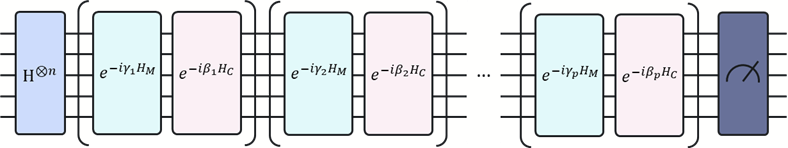

Losely speaking, the idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that we are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_m\}$ with the right angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$. Step 2 of the Qiskit Patterns focuses on preparing the circuit for optimal quantum execution through **transpilation**. The Qiskit library offers a series of **Transpilation Passes** that cater to a wide range of circuit transformations. We don't only want to get a circuit, but we want to make sure that the circuit is **optimized** for our purpose. Transpilation may involve many steps. Some of these steps are pointed out below.

* **Intiall mapping** of the qubits in the circuit (i.e. decision variables) to physical qubits on the device.
* **Unrolling** of the instructions in the quantum circuit to the hardware native instructions that the backend understands.
* **Routing** of any qubits in the circuit that interact to physical qubits that are adjacent with one another.
* **Error supression** by adding single-qubit gates to supress noise with dynamical decoupling.
* ...

As you can see there are many steps in the transpilation process. We will not go through these steps in detail here but instead load a pre-optimized quantum circuit that is ready to be run on the hardware.

In [30]:
from qiskit import qpy  # QPY is the circuit serializer in Qiskit.

In [37]:
# Load the circuits
team = 1  # Fill in your team here, either 1 or 2
if team == 1:
    backend_type = "eagle"
elif team == 2:
    backend_type == "heron"
else:
    raise ValueError("team should be 1 or 2.")

# Depth zero-circuit
with open(f"data/125node_{backend_type}_depth_zero.qpy", "rb") as fd:
    depth_zero_circuit = qpy.load(fd)[0]

# Depth one-circuit
with open(f"data/125node_{backend_type}_depth_one.qpy", "rb") as fd:
    depth_one_circuit = qpy.load(fd)[0]

In [38]:
print(depth_one_circuit)

          ┌─────────────────┐  ┌────────┐   ┌────┐               ┌──────┐     »
     q_0: ┤ Delay(3200[dt]) ├──┤ Rz(-π) ├───┤ √X ├───────────────┤1     ├─────»
          ├─────────────────┤ ┌┴────────┤   ├────┤  ┌──────┐     │      │     »
     q_1: ┤ Delay(2944[dt]) ├─┤ Rz(π/2) ├───┤ √X ├──┤0     ├─────┤      ├─────»
          ├─────────────────┤ └──┬────┬─┘┌──┴────┴─┐│  Ecr │     │      │     »
     q_2: ┤ Delay(2944[dt]) ├────┤ √X ├──┤ Rz(π/2) ├┤1     ├─────┤      ├─────»
          ├─────────────────┤    ├───┬┘  ├─────────┤└──────┘     │      │     »
     q_3: ┤ Delay(8256[dt]) ├────┤ X ├───┤ Rz(π/2) ├─────────────┤      ├─────»
          ├─────────────────┤  ┌─┴───┴──┐└──┬────┬─┘┌──────┐     │      │     »
     q_4: ┤ Delay(2944[dt]) ├──┤ Rz(-π) ├───┤ √X ├──┤1     ├─────┤      ├─────»
          ├─────────────────┤  └─┬───┬──┘┌──┴────┴─┐│  Ecr │     │      │     »
     q_5: ┤ Delay(2944[dt]) ├────┤ X ├───┤ Rz(π/2) ├┤0     ├─────┤      ├─────»
          ├─────────────────┤  ┌─┴───┴──

In [39]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Backend for team 1
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend('ibm_sherbrooke')

# Backend for team 2
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend('ibm_torino')

## 3. Execute using Qiskit Runtime primitives

Tu run QAOA we need to know the optimal parameters $\gamma_k$ and $\beta_k$ to put in the variational circuit. We will not optimize these parameters here. We will simply assume that someone has done this for us. The optimal parameters to use are

* Depth-zero QAOA: none
* Depth-one optimal (gamma, beta): (0.3927, 0.3927)  **# TODO need to check these**

Note that findin gsuch parameters is a research field in itself.

### 3.1 Define Sampler primitive

To interact with a backend we need a **Primitive**. The primitive is a way of thinking of a task that we want to run on the quantum computer. We are interesting in drawing samples from the quantum computer. This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state, for example `010101110000...` which corresponds to a candidate solution $x$ to our initial optimization problem ($\max f(x)$ or $\min f(x)$ depending on the task). We will repeat this process multiple times to generate multiple candidate solutions. 

In [43]:
from qiskit_ibm_runtime import Sampler, Options

# Since we have already done the transpilation we can skip it.
options = Options()
options.transpilation.skip_transpilation = True

sampler = Sampler(backend=backend, options=options)

### 3.2 bind the parameters for the depth-one ansatz

As mentioned above, the depth-one QAOA circuit has two parameters $\gamma$ and $\beta$ that need to be bound before we can run the circuits.

In [40]:
depth_one_circuit.parameters

ParameterView([Parameter(β1), Parameter(γ1)])

In [41]:
depth_one_bound_circuit = depth_one_circuit.assign_parameters([0.3927,  0.3927], inplace=False)

### 3.3 sample candidate solutions from the backend

We now use the sampler to send the circuits to the quantum computer.

In [44]:
sampler_job = sampler.run([depth_one_bound_circuit, depth_zero_circuit])

Each call to the sampler returns a JobId that we can use to retrive the results when they are ready.

In [46]:
sampler_job.job_id()

'cq9qj68rr08g008srgeg'

In addition, we can check the status of our jobs to see if they are finished.

In [45]:
sampler_job.status()

<JobStatus.QUEUED: 'job is queued'>

Note that after execution we will save these result to a file so that others can also take a look at them.

**TODO**

## 4. Post-process, return result in classical format

Now, we need to see which candidate solutions returned to us by the backend did well.

**TODO** Make a plot of the samples of depth one and depth two.

## Discussion and conclusion

## Appendix A: Reformulation in spin variables

Here, we rewrite the QUBO $x^TQx$ in terms of spin-variables $x_i=(1-z_i)/2$.
\begin{align}
x^TQx=\sum_{ij}Q_{ij}x_ix_j=\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j)=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
\end{align}
If we write $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$ and remove the prefactor and the constant $n^2$ term we arrive at the two equivalent formulations of the same optimization problem
\begin{align}
\max_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \max_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align}

## Appendix B: Quantum notation

The $Z$ matrices are imbedded in the quantum computer's computational space, i.e., a Hilbert space of size $2^n\times 2^n$. Therefore, you should understand terms such as $Z_iZ_j$ as the tensor product $Z_i\otimes Z_j$ imbedded in the $2^n\times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ where $I$ is the $2\times 2$ identity matrix.